<a href="https://colab.research.google.com/github/abhishek0539/Traffic_Sign_Prediction/blob/main/Traffic_Sign_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install and set up Kaggle API to download the dataset
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle

Saving kaggle.json to kaggle.json
usage: kaggle [-h] [-v] [-W] {competitions,c,datasets,d,kernels,k,models,m,files,f,config} ...
kaggle: error: the following arguments are required: command


In [3]:
# Download and unzip the Indian Traffic Sign Dataset
!kaggle datasets download -d neelpratiksha/indian-traffic-sign-dataset
!unzip indian-traffic-sign-dataset.zip -d /content/indian-traffic-sign-dataset

Dataset URL: https://www.kaggle.com/datasets/neelpratiksha/indian-traffic-sign-dataset
License(s): CC0-1.0
 93% 24.0M/25.8M [00:02<00:00, 13.1MB/s]
100% 25.8M/25.8M [00:02<00:00, 9.89MB/s]


In [5]:
# Import Libraries
import pandas as pd
import os
import numpy as np
from skimage import io, transform, exposure
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from collections import namedtuple

# Directory paths
csv_path = "/content/indian-traffic-sign-dataset/Indian-Traffic Sign-Dataset/traffic_sign.csv"
image_folder = "/content/indian-traffic-sign-dataset/Indian-Traffic Sign-Dataset/Images"

# Load dataset from CSV and images from folder
def load_dataset(csv_path, image_folder):
    data = pd.read_csv(csv_path)
    X = []
    y = []

    for index, row in data.iterrows():
        class_id = row['ClassId']
        class_folder = os.path.join(image_folder, str(class_id))

        if not os.path.exists(class_folder):
            print(f"Warning: Folder {class_folder} does not exist. Skipping...")
            continue

        for image_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, image_name)
            if not os.path.isfile(img_path):
                print(f"Warning: File {img_path} does not exist. Skipping...")
                continue

            try:
                image = io.imread(img_path, as_gray=True)
                X.append(image)
                y.append(class_id)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return np.array(X), np.array(y)

# Preprocessing function
def preprocess_dataset(X, y):
    X = np.array([transform.resize(image, (32, 32)) for image in X])
    X = np.array([exposure.equalize_adapthist(image, clip_limit=0.1) for image in X])
    X = np.expand_dims(X, axis=-1)
    y = np.eye(59)[y]
    X, y = shuffle(X, y)
    return X.astype(np.float32), y.astype(np.float32)

# Load and preprocess the dataset
X, y = load_dataset(csv_path, image_folder)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train, y_train = preprocess_dataset(X_train, y_train)
X_valid, y_valid = preprocess_dataset(X_valid, y_valid)
X_test, y_test = preprocess_dataset(X_test, y_test)

# Model parameters
Parameters = namedtuple('Parameters', [
    'num_classes', 'image_size', 'batch_size', 'max_epochs', 'log_epoch',
    'print_epoch', 'learning_rate_decay', 'learning_rate', 'l2_reg_enabled',
    'l2_lambda', 'early_stopping_enabled', 'early_stopping_patience',
    'resume_training', 'conv1_k', 'conv1_d', 'conv1_p', 'conv2_k',
    'conv2_d', 'conv2_p', 'conv3_k', 'conv3_d', 'conv3_p', 'fc4_size', 'fc4_p'
])

params = Parameters(
    num_classes=59, image_size=32, batch_size=128, max_epochs=20, log_epoch=1,
    print_epoch=1, learning_rate_decay=0.95, learning_rate=0.001, l2_reg_enabled=True,
    l2_lambda=0.0001, early_stopping_enabled=True, early_stopping_patience=5,
    resume_training=False, conv1_k=5, conv1_d=32, conv1_p=0.5, conv2_k=5,
    conv2_d=64, conv2_p=0.5, conv3_k=5, conv3_d=128, conv3_p=0.5,
    fc4_size=512, fc4_p=0.5
)

# TensorFlow model functions
def conv_relu(input, kernel_size, depth):
    conv = tf.keras.layers.Conv2D(depth, kernel_size, padding='same', activation='relu')(input)
    return conv

def pool(input, size):
    return tf.keras.layers.MaxPooling2D(pool_size=size, strides=size, padding='same')(input)

def model_pass(input, params):
    conv1 = conv_relu(input, kernel_size=params.conv1_k, depth=params.conv1_d)
    pool1 = pool(conv1, size=2)
    pool1 = tf.keras.layers.Dropout(params.conv1_p)(pool1)

    conv2 = conv_relu(pool1, kernel_size=params.conv2_k, depth=params.conv2_d)
    pool2 = pool(conv2, size=2)
    pool2 = tf.keras.layers.Dropout(params.conv2_p)(pool2)

    conv3 = conv_relu(pool2, kernel_size=params.conv3_k, depth=params.conv3_d)
    pool3 = pool(conv3, size=2)
    pool3 = tf.keras.layers.Dropout(params.conv3_p)(pool3)

    flat = tf.keras.layers.Flatten()(pool3)
    fc4 = tf.keras.layers.Dense(params.fc4_size, activation='relu')(flat)
    fc4 = tf.keras.layers.Dropout(params.fc4_p)(fc4)

    logits = tf.keras.layers.Dense(params.num_classes)(fc4)
    return logits

# Build TensorFlow model
inputs = tf.keras.Input(shape=(params.image_size, params.image_size, 1))
labels = tf.keras.Input(shape=(params.num_classes,))

logits = model_pass(inputs, params)
model = tf.keras.Model(inputs=inputs, outputs=logits)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=params.early_stopping_patience,
    restore_best_weights=True
)

# Training the model
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    epochs=params.max_epochs,
    batch_size=params.batch_size,
    callbacks=[early_stopping]
)

# Evaluate on validation and test sets
valid_loss, valid_accuracy = model.evaluate(X_valid, y_valid)
print("Validation Accuracy:", valid_accuracy)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.0396 - loss: 4.0342 - val_accuracy: 0.1106 - val_loss: 3.8177
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.1164 - loss: 3.5649 - val_accuracy: 0.3085 - val_loss: 2.5838
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2953 - loss: 2.5610 - val_accuracy: 0.5365 - val_loss: 1.6578
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4713 - loss: 1.8212 - val_accuracy: 0.6174 - val_loss: 1.3207
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5601 - loss: 1.4729 - val_accuracy: 0.7105 - val_loss: 0.9526
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6283 - loss: 1.1755 - val_accuracy: 0.7498 - val_loss: 0.8270
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6736 - loss: 1.0376 - val_accuracy: 0.7734 - val_loss: 0.6948
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7005 - loss: 0.9234 - val_accuracy: 0.7931 - val

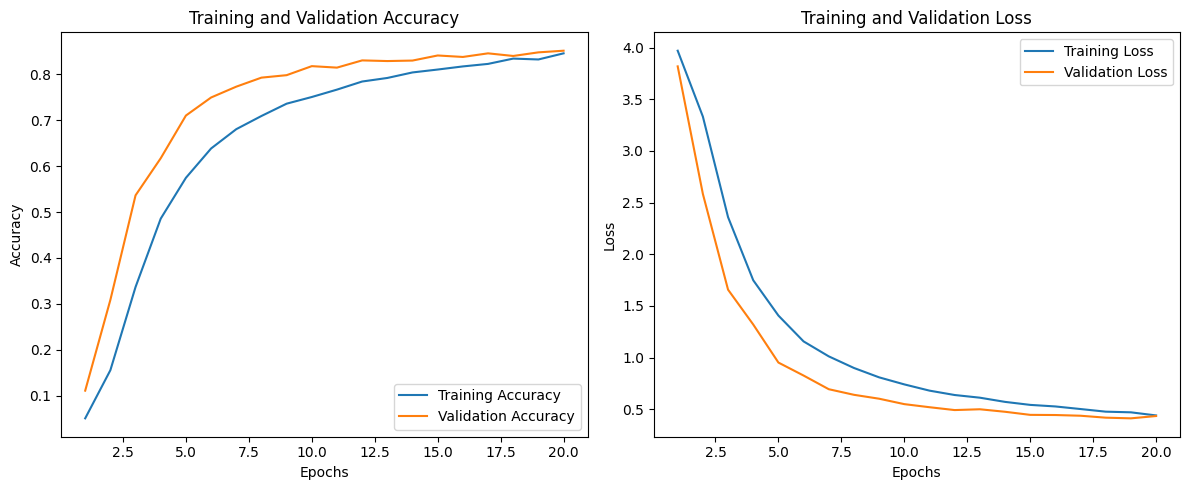

In [6]:
#Drawing the graph for Training Accuracy and Training Loss
import matplotlib.pyplot as plt

# Extract training and validation metrics from the history object
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


FileUpload(value={}, accept='image/*', description='Upload')

Image format: PNG, size: (32, 32), mode: RGBA
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


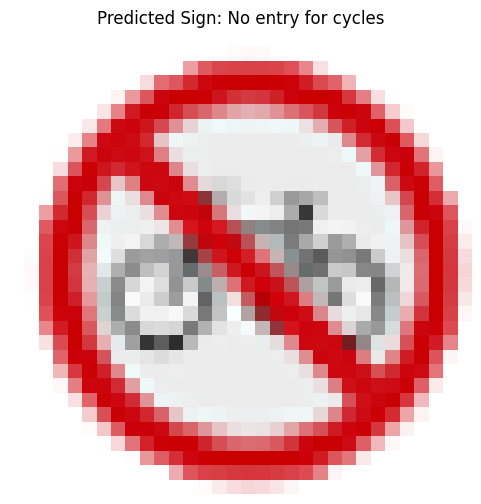

In [8]:
import pandas as pd
import numpy as np
from skimage import transform, exposure
import tensorflow as tf
from PIL import Image
import io
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import os

# Go to Directory
current_directory = os.getcwd()

# Load the sign mapping CSV file from the current directory
sign_mapping_path = os.path.join(current_directory, '/content/indian-traffic-sign-dataset/Indian-Traffic Sign-Dataset/traffic_sign.csv')
sign_mapping_df = pd.read_csv(sign_mapping_path)

# Create a dictionary mapping class IDs to sign names
sign_mapping = dict(zip(sign_mapping_df['ClassId'], sign_mapping_df['Name']))

# Define the upload widget
upload = widgets.FileUpload(accept='image/*', multiple=False)

# Preprocess the uploaded image for prediction.
def preprocess_image(image):
    if image.mode != 'L':
        image = image.convert('L')
    image = np.array(image)

    # Preprocess the image
    image = transform.resize(image, (32, 32))
    image = exposure.equalize_adapthist(image, clip_limit=0.1)
    image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)
    return image

# Predict the class of the image using the loaded model and return the sign name.
def predict_image_class(image):
    image = preprocess_image(image)
    logits = model.predict(image)
    predicted_class_index = np.argmax(logits, axis=-1)
    sign_name = sign_mapping.get(predicted_class_index[0], "Unknown Sign")
    return sign_name

# Handle the upload event and display results.
def on_upload_change(change):
    uploaded_file = change['new']

    if uploaded_file:
        file_content = next(iter(uploaded_file.values()))['content']
        try:
            image = Image.open(io.BytesIO(file_content))
            print(f"Image format: {image.format}, size: {image.size}, mode: {image.mode}")

            predicted_sign_name = predict_image_class(image)

            plt.figure(figsize=(6, 6))
            plt.imshow(image, cmap='gray')
            plt.title(f"Predicted Sign: {predicted_sign_name}")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error: {e}")

upload.observe(on_upload_change, names='value')

display(upload)